In [44]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

from Psilocybin.subjects import get_psi_dir

# These are crucial parameters - otherwise all text gets output with each letter in a word or heading as a separate unit
# instead of a text box
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Specify Arial as font type
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Specify desired place to plot here.
plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Manuscripts/Psilocybin/plots")

## Specify plotting parameters

In [41]:
animals = ["Finn", "Rey", "Rose", "Finn2"]
rasterize_scatter = True # This is crucial, default (False) will produce unweildy plots

In [3]:
ripple_thresh = 4 # 2.5 or 4

# Cut down Finn2 saline to 1hr?
chop_finn2_saline = False  # True = only use 1st hour of Finn2 saline, False = use all
finn2_append = "_1hrsalineonly" if chop_finn2_saline else ""

# ... OR only use 1hr Psilocybin for all
limit_to_1st_hr = True
chop_all_append = "_allsessions1hr" if limit_to_1st_hr else ""
finn2_append = "" if chop_all_append else finn2_append

## Load in data

In [31]:
df_grp = []
for ida, animal in enumerate(animals):
    file_use = get_psi_dir(animal, "Saline1").parent / "aggdata" / f"{animal.lower()}_rpl_features_thresh{'_'.join(str(ripple_thresh).split('.'))}{chop_all_append}.csv"
    df_animal = pd.read_csv(file_use, index_col=0)
    df_animal["Animal_name"] = animal
    df_animal["Animal"] = ida + 1
    df_grp.append(df_animal)

df_grp = pd.concat(df_grp, axis=0, ignore_index=True)
df_grp
    

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
0,0.9184,0.9992,0.9712,8275.3125,0.0808,165.151515,NaN,13.364659,Saline 1,Finn,1
1,69.9744,70.0368,70.0056,31828.8180,0.0624,233.333333,NaN,6.180823,Saline 1,Finn,1
2,70.4328,70.5104,70.4736,8196.7070,0.0776,227.272727,NaN,3.513697,Saline 1,Finn,1
3,89.4656,89.5320,89.5032,6456.5396,0.0664,157.575758,NaN,6.030679,Saline 1,Finn,1
4,120.9960,121.0720,121.0464,5693.2330,0.0760,127.272727,NaN,6.569296,Saline 1,Finn,1
...,...,...,...,...,...,...,...,...,...,...,...
7413,3538.3136,3538.4256,3538.3464,22522.9980,0.1120,107.575758,NaN,5.210325,Saline 2,Finn2,4
7414,3554.5200,3554.8728,3554.6696,42904.4570,0.3528,116.666667,NaN,20.716292,Saline 2,Finn2,4
7415,3570.0096,3570.1112,3570.0640,42776.5350,0.1016,115.151515,NaN,10.217224,Saline 2,Finn2,4
7416,3570.2440,3570.3408,3570.3096,37695.3600,0.0968,115.151515,NaN,6.340632,Saline 2,Finn2,4


In [32]:
df_grp["session"] = pd.Categorical(df_grp["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])
df_mean = df_grp.groupby(["Animal", "session"]).mean().reset_index()
# df_mean["session"] = pd.Categorical(df_mean["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])
df_mean

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_54089/1980467923.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_grp.groupby(["Animal", "session"]).mean().reset_index()


,Animal,session,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude
0,1,Saline 1,1819.107369,1819.222430,1819.164260,11912.802666,0.115061,145.867769,NaN,6.388298
1,1,Psilocybin,1526.507011,1526.637359,1526.573202,8923.877583,0.130348,137.832041,NaN,6.044954
2,1,Saline 2,1158.382781,1158.488770,1158.437000,14294.726695,0.105989,140.786901,NaN,6.732229
3,2,Saline 1,1289.023148,1289.127409,1289.076052,9786.125891,0.104260,138.882848,NaN,8.091481
4,2,Psilocybin,1356.030054,1356.163432,1356.096053,9337.580465,0.133378,138.769902,NaN,8.751123
5,2,Saline 2,1534.030831,1534.132675,1534.083939,9615.349164,0.101843,138.536032,NaN,7.895941
6,3,Saline 1,1442.252948,1442.363153,1442.308559,9869.911486,0.110205,143.843434,NaN,7.854424
7,3,Psilocybin,1393.866546,1393.993939,1393.928036,95038.253609,0.127393,164.269338,NaN,5.544260
8,3,Saline 2,1693.668223,1693.782410,1693.725882,13101.903144,0.114186,145.355681,NaN,6.429663
9,4,Saline 1,1708.056916,1708.171967,1708.112520,23707.618730,0.115051,137.620969,NaN,5.750901


## Example plotting size and parameters here

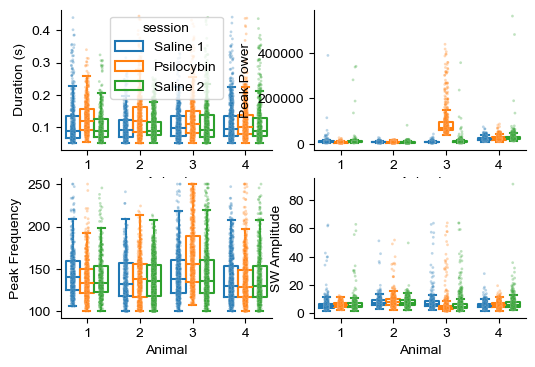

In [45]:
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
titles = ["Duration (s)", "Peak Power", "Peak Frequency", "SW Amplitude"]
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
for idf, feature in enumerate(features):
    ax = axs.reshape(-1)[idf]
    plot_legend = True if idf == 0 else False
    sns.boxplot(data=df_grp, x="Animal", y=feature, dodge=True, hue="session", showfliers=False, fill=False, 
                legend=plot_legend, ax=ax)
    sns.stripplot(data=df_grp, x="Animal", y=feature, dodge=True, hue="session", size=2, 
                  linewidth=0.1, edgecolor="w", alpha=0.3, rasterized=rasterize_scatter,
                  legend=False, ax=ax)
    ax.set_ylabel(titles[idf])
    sns.despine(ax=ax)

fig.savefig(plot_dir / "ripple_features.pdf", dpi=600)

### Investigate Rose Psilocybin session - why are peak frequency and power off by so much?!?

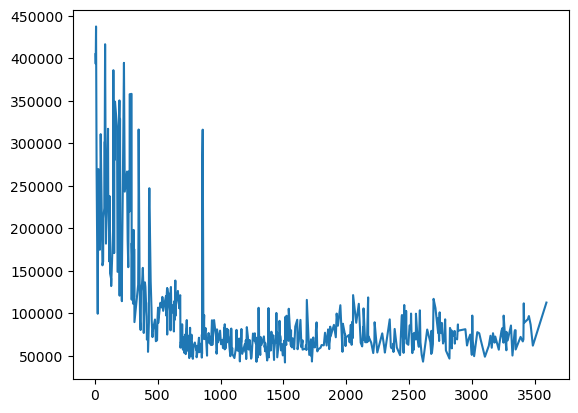

In [7]:
df_rose = df_grp[df_grp.Animal == "Rose"]
df_rose_psi = df_rose[df_rose.session == "Psilocybin"]
_, ax = plt.subplots()
ax.plot(df_rose_psi.peak_time, df_rose_psi.peak_power)

<Axes: xlabel='session', ylabel='duration'>

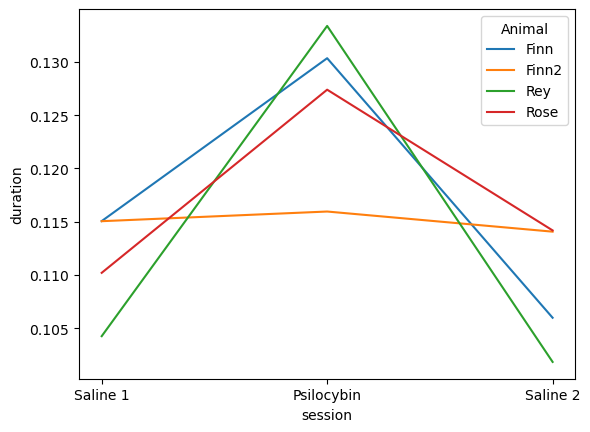

In [8]:
_, ax = plt.subplots()
sns.lineplot(data=df_mean, x="session", y="duration", hue="Animal", ax=ax)

FEATURE: duration
Saline 1 mean = 0.11184608733247055, Psilocybin mean = 0.1258749704375244
Mann-Whitney U test p-value=8.01567678153805e-31

Psilocybin mean = 0.1258749704375244, Saline 2 mean = 0.10796791277258881
Mann-Whitney U test p-value=1.035708959109098e-46

Saline 1 mean = 0.11184608733247055, Saline 2 mean = 0.10796791277258881
Mann-Whitney U test p-value=0.08128581962842109



FEATURE: peak_power
Saline 1 mean = 15134.121398357114, Psilocybin mean = 34972.81836200236
Mann-Whitney U test p-value=6.228087613673036e-47

Psilocybin mean = 34972.81836200236, Saline 2 mean = 15368.549041861372
Mann-Whitney U test p-value=3.238293269990262e-70

Saline 1 mean = 15134.121398357114, Saline 2 mean = 15368.549041861372
Mann-Whitney U test p-value=4.835486120046098e-07



FEATURE: peak_frequency_bp
Saline 1 mean = 141.1888011109801, Psilocybin mean = 143.97463002114165
Mann-Whitney U test p-value=0.03085264390217608

Psilocybin mean = 143.97463002114165, Saline 2 mean = 140.6406353252148

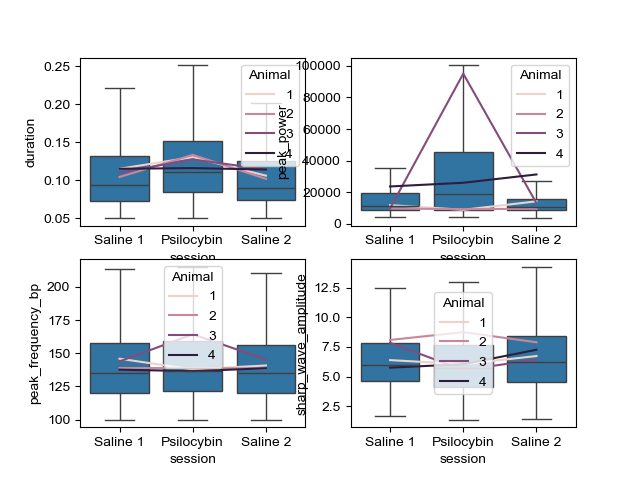

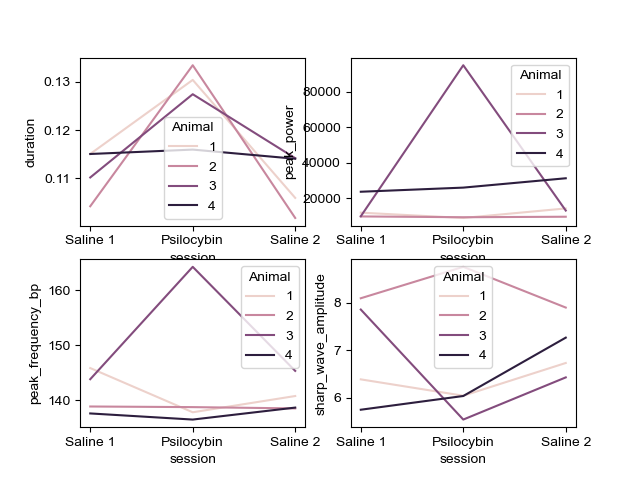

In [50]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    # sns.violinplot(data=df_grp, x="session", y=feature, cut=0.1, inner="quart", ax=a)
    sns.boxplot(data=df_grp, x="session", y=feature, showfliers=False, ax=a)
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)
    # sal1_df = df_grp[df_grp.session == "Saline 1"]
    # psi_df = df_grp[df_grp.session == "Psilocybin"]
    # sal2_df = df_grp[df_grp.session == "Saline 2"]

    # sal1_v_psi = stats.mannwhitneyu(sal1_df[feature].values, psi_df[feature].values)
    # psi_v_sal2 = stats.mannwhitneyu(psi_df[feature].values, sal2_df[feature].values)
    # sal1_v_sal2 = stats.mannwhitneyu(sal1_df[feature].values, sal2_df[feature].values)

    print(f"FEATURE: {feature}")
    for grps_use in [["Saline 1", "Psilocybin"], ["Psilocybin", "Saline 2"], ["Saline 1", "Saline 2"]]:
        grp1_vals = df_grp[df_grp.session == grps_use[0]][feature].values
        grp2_vals = df_grp[df_grp.session == grps_use[1]][feature].values
        print(f"{grps_use[0]} mean = {np.mean(grp1_vals)}, {grps_use[1]} mean = {np.mean(grp2_vals)}")
        mannu_stats = stats.mannwhitneyu(grp1_vals, grp2_vals)
        print(f"Mann-Whitney U test p-value={mannu_stats.pvalue}\n")
    print("\n")

_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)

In [8]:
df_split = df_grp[np.isin(df_grp.session.values, ["Saline 1", "Psilocybin"])]

<Axes: ylabel='duration'>

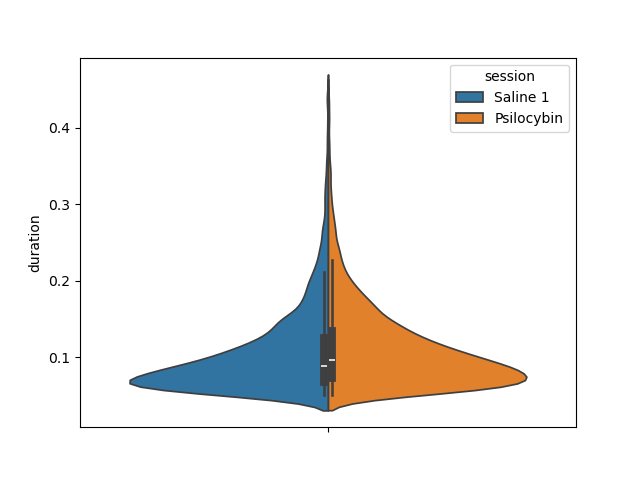

In [9]:
_, ax = plt.subplots()
df_split = df_grp[np.isin(df_grp.session.values, ["Saline 1", "Psilocybin"])]
sns.violinplot(data=df_split, y="duration", hue="session", split=True, ax=ax)

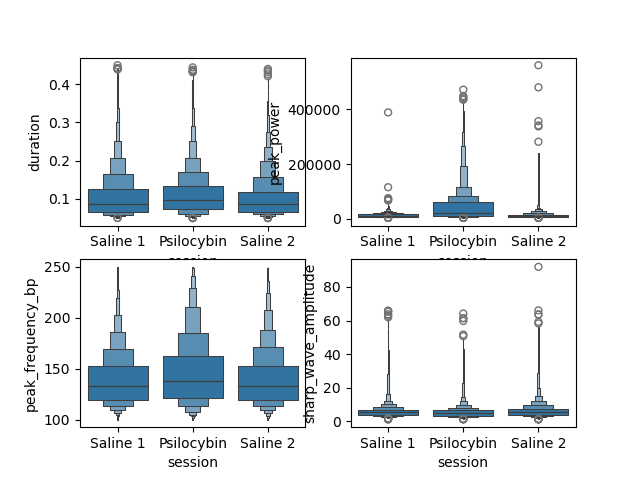

In [10]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.boxenplot(data=df_grp, x="session", y=feature, ax=a)